In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/buetpaper/train'
validation_dir = '/content/drive/MyDrive/buetpaper/val'
test_dir='/content/drive/MyDrive/buetpaper/test'

In [4]:
import os
trainclass_subset=os.listdir(train_dir)
validclass_subset =os.listdir(validation_dir)

In [5]:
trainclass_subset

['Stemborer',
 'Brown_Spot',
 'Neck_Blast',
 'BLB',
 'Healthy_Plant',
 'Hispa',
 'BPH',
 'Sheath_Blight_Rot',
 'False_Smut']

In [6]:
validclass_subset

['False_Smut',
 'BLB',
 'Sheath_Blight_Rot',
 'Neck_Blast',
 'BPH',
 'Stemborer',
 'Healthy_Plant',
 'Brown_Spot',
 'Hispa']

In [7]:
import tensorflow 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# **Train Data with simple CNN**

In [8]:
#image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
)


In [9]:
# load train data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                   )
#load val data
val_generator = val_datagen.flow_from_directory(validation_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  color_mode="rgb",
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  )
# load test data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  color_mode="rgb",
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  )

Found 994 images belonging to 9 classes.
Found 208 images belonging to 9 classes.
Found 224 images belonging to 9 classes.


# **Train with VGG16**

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Input, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, GlobalMaxPooling2D
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [11]:
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


58900480/58889256 [==============================] - 0s 0us/step


In [12]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [13]:
x = vgg.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
output_layer = Dense(9, activation='softmax', name='softmax')(x)
model = Model(inputs=vgg.input, outputs=output_layer)
   

In [14]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0b151af090> False
<keras.layers.convolutional.Conv2D object at 0x7f0b07ab0ed0> False
<keras.layers.convolutional.Conv2D object at 0x7f0b06a68750> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0b066d5790> False
<keras.layers.convolutional.Conv2D object at 0x7f0b1723b550> False
<keras.layers.convolutional.Conv2D object at 0x7f0b05c982d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0b05c9ff10> False
<keras.layers.convolutional.Conv2D object at 0x7f0b05caa510> False
<keras.layers.convolutional.Conv2D object at 0x7f0b05ca7b10> False
<keras.layers.convolutional.Conv2D object at 0x7f0b05cafe90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0b05cba110> False
<keras.layers.convolutional.Conv2D object at 0x7f0b05cb6a10> False
<keras.layers.convolutional.Conv2D object at 0x7f0b05c9f990> False
<keras.layers.convolutional.Conv2D object at 0x7f0b05cc2810> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0b05cce150>

In [16]:
from keras.optimizer_v1 import Adam
EPOCHS=30
model.compile(loss="categorical_crossentropy", optimizer="Adam",metrics=["accuracy"])

In [17]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)


In [18]:
modelcheck = ModelCheckpoint('/content/gdrive/MyDrive/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)


In [19]:
history = model.fit_generator(train_generator,validation_data=val_generator,epochs=EPOCHS,verbose=1,callbacks=[es])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/30
32/32 [==============================] - 279s 8s/step - loss: 1.8908 - accuracy: 0.3893 - val_loss: 1.0121 - val_accuracy: 0.6827
Epoch 2/30
32/32 [==============================] - 15s 481ms/step - loss: 1.0797 - accuracy: 0.6318 - val_loss: 0.8907 - val_accuracy: 0.6923
Epoch 3/30
32/32 [==============================] - 15s 465ms/step - loss: 0.9362 - accuracy: 0.6952 - val_loss: 0.6379 - val_accuracy: 0.7933
Epoch 4/30
32/32 [==============================] - 15s 464ms/step - loss: 0.7306 - accuracy: 0.7384 - val_loss: 0.5467 - val_accuracy: 0.8173
Epoch 5/30
32/32 [==============================] - 15s 469ms/step - loss: 0.5080 - accuracy: 0.8239 - val_loss: 0.4850 - val_accuracy: 0.8365
Epoch 6/30
32/32 [==============================] - 15s 463ms/step - loss: 0.4802 - accuracy: 0.8390 - val_loss: 0.3687 - val_accuracy: 0.8750
Epoch 7/30
32/32 [==============================] - 15s 469ms/step - loss: 0.3719 - accuracy: 0.8843 - val_loss: 0.2889 - val_accuracy: 0.9183
E

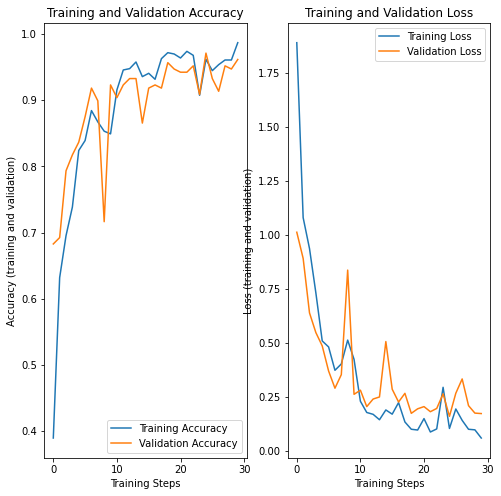

In [20]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [21]:
model.save("/content/drive/MyDrive/VGG16/DenseNetFT.h5")

In [22]:
loss_val, acc_val = model.evaluate(val_generator, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

7/7 [==============================] - 1s 145ms/step - loss: 0.1713 - accuracy: 0.9615
Validation: accuracy = 0.961538  ;  loss_v = 0.171297


In [23]:
loss_test, acc_test = model.evaluate(test_generator, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

7/7 [==============================] - 51s 8s/step - loss: 0.1584 - accuracy: 0.9554
Test: accuracy = 0.955357  ;  loss_v = 0.158369


In [24]:
loss_train, acc_train = model.evaluate(train_generator, verbose=1)
print("Train: accuracy = %f  ;  loss_v = %f" % (acc_train, loss_train))

32/32 [==============================] - 14s 435ms/step - loss: 0.0367 - accuracy: 0.9899
Train: accuracy = 0.989940  ;  loss_v = 0.036680


# **Image prediction**

**Test Data Confusion matrix & Classification report**

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
pred_test = model.predict_generator(test_generator)
pred_test = np.argmax(pred_test, axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [30]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(test_generator.classes, pred_test, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       0.91      0.95      0.93        22
              BPH       0.92      0.92      0.92        12
       Brown_Spot       1.00      1.00      1.00        18
       False_Smut       0.94      1.00      0.97        15
    Healthy_Plant       0.97      0.97      0.97        36
            Hispa       0.92      0.92      0.92        12
       Neck_Blast       0.98      1.00      0.99        44
Sheath_Blight_Rot       0.94      0.88      0.91        34
        Stemborer       0.97      0.94      0.95        31

         accuracy                           0.96       224
        macro avg       0.95      0.95      0.95       224
     weighted avg       0.96      0.96      0.96       224



In [31]:
test_confusion_matrix = confusion_matrix(test_generator.classes, pred_test)
test_confusion_matrix

array([[21,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 11,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 18,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 35,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 44,  0,  0],
       [ 2,  0,  0,  1,  1,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  1, 29]])

In [32]:
test_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        test_sum[i]=test_sum[i]+test_confusion_matrix[i][j]

In [33]:
test_confusion_matrix_percentage = test_confusion_matrix.astype(np.float32)

In [34]:
for i in range(9):
    for j in range(9):
        test_confusion_matrix_percentage[i][j]=test_confusion_matrix_percentage[i][j]/test_sum[i]

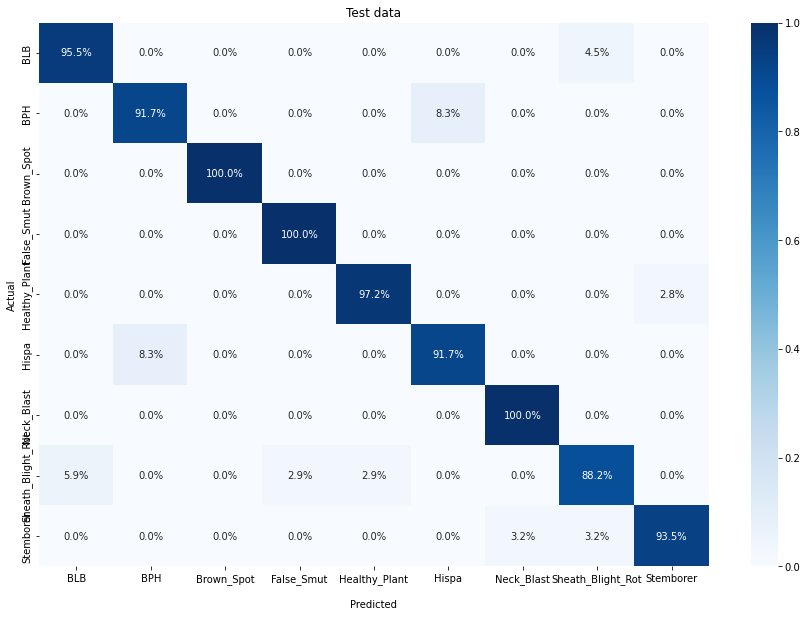

In [35]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(test_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Test data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Validation Data Confusion matrix and classification report**

In [36]:
pred_val = model.predict_generator(val_generator)
pred_val = np.argmax(pred_val, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [37]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(val_generator.classes, pred_val, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       0.90      0.95      0.93        20
              BPH       1.00      0.90      0.95        10
       Brown_Spot       1.00      0.94      0.97        16
       False_Smut       1.00      1.00      1.00        13
    Healthy_Plant       0.97      0.97      0.97        35
            Hispa       0.90      0.90      0.90        10
       Neck_Blast       1.00      1.00      1.00        42
Sheath_Blight_Rot       0.91      0.91      0.91        32
        Stemborer       0.97      1.00      0.98        30

         accuracy                           0.96       208
        macro avg       0.96      0.95      0.96       208
     weighted avg       0.96      0.96      0.96       208



In [38]:
val_confusion_matrix = confusion_matrix(val_generator.classes, pred_val)
val_confusion_matrix

array([[19,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  9,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 15,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0, 13,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 34,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  9,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0, 42,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0, 29,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30]])

In [39]:
val_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        val_sum[i]=val_sum[i]+val_confusion_matrix[i][j]
        
        
val_confusion_matrix_percentage = val_confusion_matrix.astype(np.float32)

for i in range(9):
    for j in range(9):
        val_confusion_matrix_percentage[i][j]=val_confusion_matrix_percentage[i][j]/val_sum[i]


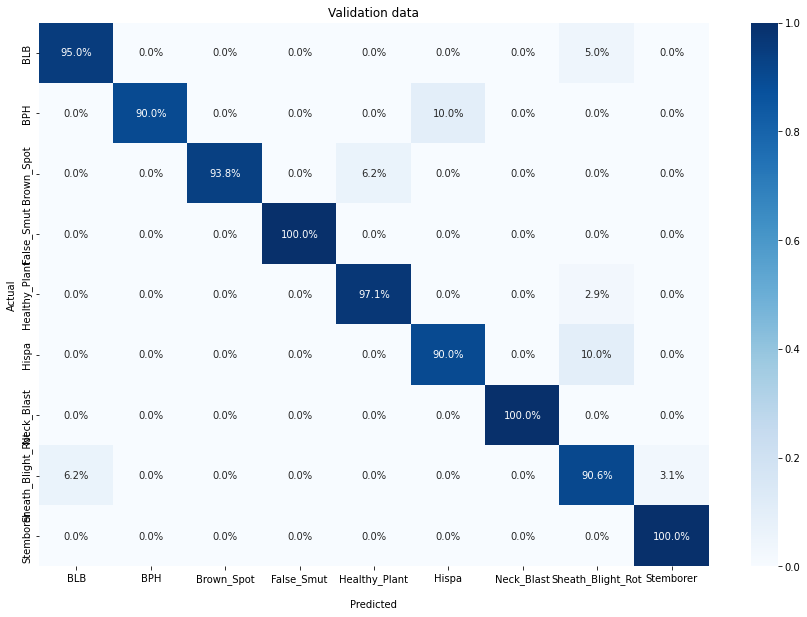

In [40]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(val_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Validation data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Train Data Confusion matrix & Classification report**


In [72]:
train_dir = '/content/drive/MyDrive/buetpaper/train'

In [73]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                   )

Found 994 images belonging to 9 classes.


In [74]:
model=load_model('/content/drive/MyDrive/VGG16/DenseNetFT.h5')

In [75]:
pred_train = model.predict_generator(train_generator)
pred_train = np.argmax(pred_train, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [77]:
#Confution Matrix and Classification Report
print('Classification Report')
target_names = ['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer']
print(classification_report(train_generator.classes, pred_train, target_names=target_names))

Classification Report
                   precision    recall  f1-score   support

              BLB       1.00      1.00      1.00        96
              BPH       1.00      1.00      1.00        49
       Brown_Spot       1.00      1.00      1.00        77
       False_Smut       1.00      1.00      1.00        65
    Healthy_Plant       1.00      1.00      1.00       163
            Hispa       1.00      1.00      1.00        51
       Neck_Blast       1.00      1.00      1.00       200
Sheath_Blight_Rot       1.00      1.00      1.00       153
        Stemborer       1.00      1.00      1.00       140

         accuracy                           1.00       994
        macro avg       1.00      1.00      1.00       994
     weighted avg       1.00      1.00      1.00       994



In [76]:
train_confusion_matrix = confusion_matrix(train_generator.classes, pred_train)
train_confusion_matrix

array([[ 96,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  49,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  77,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  65,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 163,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  51,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 200,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 153,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 140]])

In [78]:
train_sum=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(9):
    for j in range(9):
        train_sum[i]=train_sum[i]+train_confusion_matrix[i][j]
        
        
train_confusion_matrix_percentage = train_confusion_matrix.astype(np.float32)

for i in range(9):
    for j in range(9):
        train_confusion_matrix_percentage[i][j]=train_confusion_matrix_percentage[i][j]/train_sum[i]


In [79]:
train_sum

array([ 96,  49,  77,  65, 163,  51, 200, 153, 140])

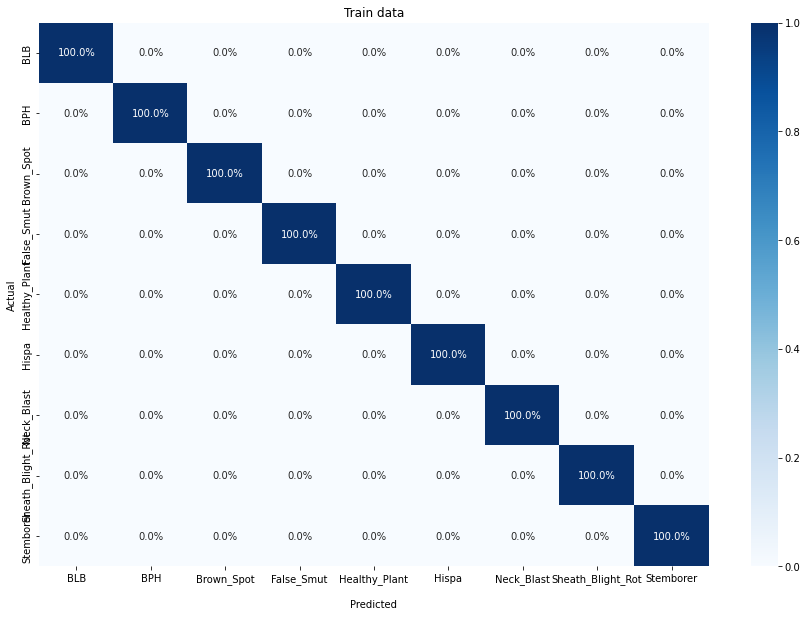

In [80]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(train_confusion_matrix_percentage, annot=True, 
            fmt='.1%', cmap='Blues')

ax.set_title('Train data');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])
ax.yaxis.set_ticklabels(['BLB','BPH','Brown_Spot','False_Smut','Healthy_Plant','Hispa','Neck_Blast','Sheath_Blight_Rot','Stemborer'])

## Display the visualization of the Confusion Matrix.
plt.show()